#  Demo code instruction
This is a demo code that implements the dual equivalent inclusion (DEI) method in an anti-plane problem. 

Running the code from the top, this code generates comparisons between the DEI solution with some elastostatic benchmark problems shown in the paper. The code outline is shown in the following workflow. 
The code will require `numba` module for the accerelation (otherwise, please erase `from numba import jit` and`@jit`).

# Workflow

1. Kernel definition
1. Geometric setting
1. Deformation computation
1. Visualisation
    1. with homogeneous solution
    1. with Benchmark 1
    1. with Benchmark 2

# Kernel definition 

Displacement, strain and traction nuclei are defined for semi-infinite and finite-sized piecewise anti-plane slip of full-space. Some visualisation scripts are attached for code checking. 

In [1]:
#Defining anti-plane kernels

#%matplotlib notebook 
import math
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

@jit
def mode3_u3_six(dx1,dx2):
#displacement due to anti-plane slip inserted downward vertically (constant on a semi-infinite flat fault). 
    return np.arctan2(dx1,dx2)/(2.*math.pi)
@jit
def mode3_u3_inclined(dx1,dx2,theta):
#displacement due to arbitrarily inclined anti-plane slip (constant on a semi-infinite flat fault).
#theta...anticlockwise angle from six o'clock position
    return ((np.arctan2(dx1,dx2)+math.pi+theta)%(2.*math.pi)-math.pi)/(2.*math.pi)
@jit
def mode3_ep31(dx1,dx2):
#31 component of the strain due to screw-dislocation
    return dx2/(dx1**2+dx2**2)/(2.*math.pi)
@jit
def mode3_ep32(dx1,dx2):
#32 component of the strain due to screw-dislocation
    return -dx1/(dx1**2+dx2**2)/(2.*math.pi)



<ipython-input-3-138ba10f8fef>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u3)


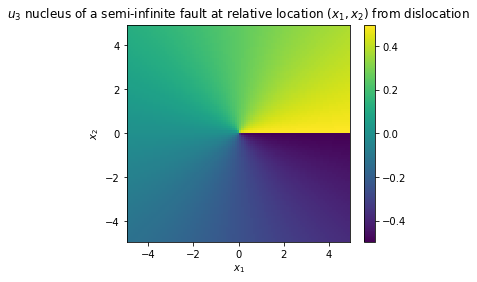

In [3]:
#A test code for the anti-plane kernel
#visualising displacement and strain over X, Y=-5,...,5 
#by using discretization length dx=0.1

#1..Set a grid with relative receiver coordinate values (from the anti-plane dislocation) 
x = np.arange(-5+0.1*0.5, 5,0.1) #x=-5+0.1/2,-5+0.1*(1+1/2),..,5-0.1/2 #half-integer shift for avoiding 0 divide
y = np.arange(-5+0.1*0.5, 5,0.1) #same as x.
X, Y = np.meshgrid(x, y) #generating mesh grid

#print(X) #2D array storing 2D lattice numbers


#2..Calculating kernel values
u3 = mode3_u3_inclined(X,Y,math.pi/2) #u3 for grid points
ep31=mode3_ep31(X,Y) #du3/dx1 for grid points
ep32=mode3_ep32(X,Y) #du3/dx2 for grid points

#print(u3[100])
#print(u3[100][51])

#3..Plot 2D heatmap
fig = plt.figure(figsize=(5, 4)) #sizing a figure
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.pcolor(X, Y, u3) 
plt.title('$u_3$ nucleus of a semi-infinite fault at relative location $(x_1,x_2)$ from dislocation')
#plt.pcolor(X, Y, ep31)
#plt.title('$\partial_1 u_3$ nucleus of a semi-infinite fault at relative location $(x_1,x_2)$ from dislocation')
#plt.pcolor(X, Y, ep32) 
#plt.title('$\partial_1 u_2$ nucleus of a semi-infinite fault at relative location $(x_1,x_2)$ from dislocation')
plt.colorbar()
plt.show()
#fig = plt.figure(figsize=(5, 4)) #sizing a figure
#plt.pcolor(X, Y, ep31) 
#plt.pcolor(X, Y, ep32) 
#plt.colorbar()
#plt.show()


In [5]:
#discretised nuclei, using the previously defined dislocation kernel 

@jit
def discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal):
#displacement u3 due to inclined anti-plane slip distributed over a finite fault
#fault normal is supposed to be oriented crockwise by pi/2 from the along-dislocation vector directed to the edges of superoised dislocations),
    theta_normal=math.atan2(fault_normal[1],fault_normal[0]) #atan2(y,x)=atan(|y|/|x|)+quadrantal shift.
    relative_receiver_location_from_fault_edge=relative_receiver_location_from_fault_center
    dx_vect=np.zeros(2)
    dx_vect[0]=-fault_normal[1]*fault_length
    dx_vect[1]=fault_normal[0]*fault_length
    relative_receiver_location_from_fault_edge=-0.5*dx_vect+relative_receiver_location_from_fault_edge # contribution from the longer dislocation
    nuclei=mode3_u3_inclined(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1],theta_normal)
    relative_receiver_location_from_fault_edge=+dx_vect+relative_receiver_location_from_fault_edge # contribution from the shorter dislocation
    nuclei=nuclei-mode3_u3_inclined(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1],theta_normal)
    return nuclei
@jit
def discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal):
#du3/dx1 ver. of discretised_u3_nuclei
    relative_receiver_location_from_fault_edge=relative_receiver_location_from_fault_center
    dx_vect=np.zeros(2)
    dx_vect[0]=-fault_normal[1]*fault_length
    dx_vect[1]=fault_normal[0]*fault_length
    relative_receiver_location_from_fault_edge=-0.5*dx_vect+relative_receiver_location_from_fault_edge
    nuclei=mode3_ep31(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1])
    relative_receiver_location_from_fault_edge=+dx_vect+relative_receiver_location_from_fault_edge
    nuclei=nuclei-mode3_ep31(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1])
    return nuclei
@jit
def discretised_ep32_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal):
#du3/dx2 ver. of discretised_u3_nuclei
    relative_receiver_location_from_fault_edge=relative_receiver_location_from_fault_center
    dx_vect=np.zeros(2)
    dx_vect[0]=-fault_normal[1]*fault_length
    dx_vect[1]=fault_normal[0]*fault_length
    relative_receiver_location_from_fault_edge=-0.5*dx_vect+relative_receiver_location_from_fault_edge
    nuclei=mode3_ep32(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1])
    relative_receiver_location_from_fault_edge=+dx_vect+relative_receiver_location_from_fault_edge
    nuclei=nuclei-mode3_ep32(relative_receiver_location_from_fault_edge[0],relative_receiver_location_from_fault_edge[1])
    return nuclei
@jit
def discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity):
#traction ver. of discretised_u3_nuclei
#requiring the normal vector of the receiver (receiver_normal) and rigidity (medium_rigidity) additionally
    return \
    (receiver_normal[0] * discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)\
    +receiver_normal[1]* discretised_ep32_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal))\
    *medium_rigidity


<ipython-input-4-018483a34a47>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, ep31)


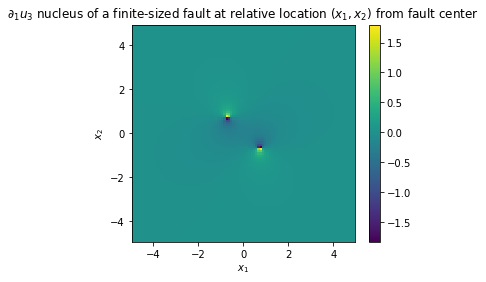

In [4]:
#A test code for the discretised anti-plane kernel
#visualising displacement and strain over X,Y=-5,...,5 
#by using discretization length dx=0.1

#1..Set a grid with relative receiver coordinate values (from the anti-plane dislocation) 
x = np.arange(-5+0.1*0.5, 5,0.1) #x=-5+0.1/2,-5+0.1*(1+1/2),..,5-0.1/2 #half-integer shift for avoiding 0 divide
y = np.arange(-5+0.1*0.5, 5,0.1) #same as x.
X, Y = np.meshgrid(x, y) #generating mesh grid

#print(X) #2D array storing 2D lattice numbers
#print(X[0][0]) # storing the edge at the (0,0)-component.
#print(X[0][99])


#2..Calculating kernel values
u3=np.zeros([100,100])
ep31=np.zeros([100,100])
ep32=np.zeros([100,100])
T3=np.zeros([100,100])

buffer=np.array([0,1])
#print(u3)
buf_location=np.zeros(2)
buf_normal=np.array([0.707106781,0.707106781])
#print(buf_normal)
for i in range(0,100):
    for j in range(0,100):
        buf_location[0]=X[i][j]
        buf_location[1]=Y[i][j]
        u3[i][j]=discretised_u3_nuclei(buf_location,2,buf_normal) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        ep31[i][j]=discretised_ep31_nuclei(buf_location,2,buf_normal) #discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        ep32[i][j]=discretised_ep32_nuclei(buf_location,2,buf_normal) #discretised_ep32_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        T3[i][j]=discretised_traction_nuclei(buf_location,2,buf_normal,buffer,1) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)


#3..Plot 2D heatmap
fig = plt.figure(figsize=(5, 4)) #sizing a figure
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.pcolor(X, Y, u3) 
#plt.title('$u_3$ nucleus of of a finite-sized fault at relative location $(x_1,x_2)$ from fault center')
plt.pcolor(X, Y, ep31) 
plt.title('$\partial_1 u_3$ nucleus of a finite-sized fault at relative location $(x_1,x_2)$ from fault center')
#plt.pcolor(X, Y, ep32) 
#plt.title('$\partial_2 u_3$ nucleus of a finite-sized fault at relative location $(x_1,x_2)$ from fault center')
#plt.pcolor(X, Y, T3) 
plt.colorbar()
plt.show()


# Geometric setting

Rectangular material interface of $x_1,x_2$-axial symmetry is assumed in the demo code. The setting in the upper half plane ($x_2>0$) is here for the mirror image. 

Numerical parameters are the size of elements (`DX_tot`) and the numbers of elements along sides (`2*LenperDX` for vertical sides and `WidperDX` for horizontal sides, respectively). The products of them give the lengths of sides. Parameter sets used in the paper lie just below. 

In [252]:
#Geometrical parameter set for a square shape damage zone (Fig.6 in the paper)
#DX_tot=0.1
#LenperDX=20
#WidperDX=20


#Geometrical parameter set for comparing the result with Benchmark 1 aftermentioned
#DX_tot=0.1
#LenperDX=400
#WidperDX=20

#Geometrical parameter set for comparing the result with Benchmark 2 aftermentioned 
DX_tot=0.1
LenperDX=20
WidperDX=800



LenperDX_doubled=LenperDX*2 #doubled LenperDX for mirror images
Num_elements_tot=2*LenperDX_doubled+2*WidperDX
Length_damagezone=LenperDX*DX_tot 
Width_damagezone=WidperDX*DX_tot



In [10]:
def line_discretisation(apex_location_init, apex_location_fin,num_of_elements,center_location_of_elements,normal_vect_elements):
#Discretising a line into segments with a structure grid
#Input: apex location(init,fin) and # of elements
#Output: center location of elements, normal vectors, discretisation length 
#(Normals are oriented crockwise by pi/2 from the relative vector of apex_location_fin from apex_location_init: the along-dislocation vector directed to the edges of superposed dislocation)
    dx=apex_location_fin-apex_location_init
    dx=dx/num_of_elements
    
    normal_vect_line=np.zeros(2)
    normal_vect_line[0]=dx[1]
    normal_vect_line[1]=-dx[0]
    buf=np.linalg.norm(normal_vect_line)
    normal_vect_line=normal_vect_line/buf
    
    for i in range(num_of_elements):
        center_location_of_elements[i]=(0.5+i)*dx+apex_location_init
        normal_vect_elements[i]=normal_vect_line
    return (dx[0]**2+dx[1]**2)**0.5 #discretisation length


In [253]:
#Subdividing material interface

#location of apexes (top right, top left, bottom right, bottom left)
x_apex_TR=np.array([+Width_damagezone*0.5,+Length_damagezone]) 
x_apex_TL=np.array([-Width_damagezone*0.5,+Length_damagezone]) 
x_apex_BR=np.array([+Width_damagezone*0.5,-Length_damagezone]) 
x_apex_BL=np.array([-Width_damagezone*0.5,-Length_damagezone]) 

#location of elements on sides (left, right, top, bottom)
loc_elements_L=np.zeros((LenperDX_doubled,2))
loc_elements_R=np.zeros((LenperDX_doubled,2))
loc_elements_T=np.zeros((WidperDX,2))
loc_elements_B=np.zeros((WidperDX,2))
#normal vectors of elements on sides (left, right, top, bottom)
normal_elements_L=np.zeros((LenperDX_doubled,2))
normal_elements_R=np.zeros((LenperDX_doubled,2))
normal_elements_T=np.zeros((WidperDX,2))
normal_elements_B=np.zeros((WidperDX,2))

#setting elements counterclockwise (-> normal vectors are set exterior by line_discretisation)
line_discretisation(x_apex_TR,x_apex_TL,WidperDX,loc_elements_T,normal_elements_T)
line_discretisation(x_apex_TL,x_apex_BL,LenperDX_doubled,loc_elements_L,normal_elements_L)
line_discretisation(x_apex_BL,x_apex_BR,WidperDX,loc_elements_B,normal_elements_B)
line_discretisation(x_apex_BR,x_apex_TR,LenperDX_doubled,loc_elements_R,normal_elements_R)
#print(loc_elements_R)
#print(normal_elements_R)

loc_elements_tot=np.concatenate([loc_elements_T, loc_elements_L,loc_elements_B,loc_elements_R])
normal_elements_tot_exterior=np.concatenate([normal_elements_T, normal_elements_L,normal_elements_B,normal_elements_R])
#print(loc_elements_tot)
#print(normal_elements_tot_exterior)

# Deformation computation

Associated dual equivalent inclusions are computed in a manner of linear inversion. 
The concerned slip distribution is the semi-infinite slip along $x_2$ axis distanced by 1 from the surface of half space. 

Numerical parameters are the rigidity in the sub-domain (`MU_in` for the inside of the rectangular and `MU_out` for horizontal sides, respectively). The parameter sets used in the paper lie just below. 

In [254]:
#Giving material parameters to volumes

#a homogeneous case
#MU_in=1
#MU_out=1.

#used by the authors in comparing the result with Benchmark 1
#MU_in=1
#MU_out=2.

#used by the authors in comparing the result with Benchmark 2
MU_in=1
MU_out=3.


In [255]:
#Calculating kernels for contiunity conditions

ker_u3_in =np.zeros([Num_elements_tot,Num_elements_tot])
ker_u3_out=np.zeros([Num_elements_tot,Num_elements_tot])
ker_T3_in =np.zeros([Num_elements_tot,Num_elements_tot])
ker_T3_out=np.zeros([Num_elements_tot,Num_elements_tot])

buf_relative_center_location=np.zeros(2)
EPSILON_UPPER_LOWER_SHIFT=1.0e-10 #positive iota for discriminating upper and lower one-sided limits approaching the receiver boundary
for i in range(Num_elements_tot):
    for j in range(Num_elements_tot):
        buf_relative_center_location=loc_elements_tot[i]-loc_elements_tot[j]-normal_elements_tot_exterior[i]*EPSILON_UPPER_LOWER_SHIFT #lower side of boundary (within the interior volume)
        ker_u3_in[i][j]=discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[j]) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        ker_T3_in[i][j]=discretised_traction_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[j],normal_elements_tot_exterior[i],MU_in) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)

        buf_relative_center_location=loc_elements_tot[i]-loc_elements_tot[j]+normal_elements_tot_exterior[i]*EPSILON_UPPER_LOWER_SHIFT #upper side of boundary (within the exterior volume)
        ker_u3_out[i][j]=discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[j]) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        ker_T3_out[i][j]=discretised_traction_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[j],normal_elements_tot_exterior[i],MU_out) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)


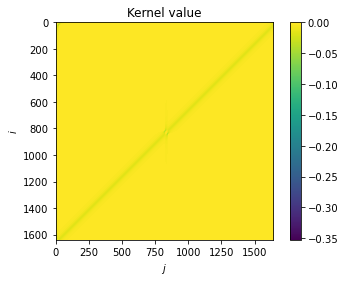

In [150]:
#Vizualising kernels
#plt.pcolor(ker_u3_out-ker_u3_in) #discontinous part of displacement nucleus
plt.imshow(ker_u3_out+ker_u3_in) #continous part of displacement nucleus
#plt.imshow(ker_T3_out-ker_T3_in) #cancelling when MU_in=MU_out
#plt.imshow(ker_T3_out+ker_T3_in)
plt.xlabel('$j$')
plt.ylabel('$i$')
plt.title('Kernel value')
plt.colorbar()
plt.show()

In [256]:
#Calculating a homogeneous solution
#Example: dislocation cutting the material interface
#The center of the original fault is located at the origin.


u3_homogeneous_in=np.zeros(Num_elements_tot)
T3_homogeneous_in=np.zeros(Num_elements_tot)

u3_homogeneous_out=np.zeros(Num_elements_tot)
T3_homogeneous_out=np.zeros(Num_elements_tot)

normal_original_source=np.array([1,0])
#fault_length_original=50
fault_length_original2=2

for i in range(Num_elements_tot):
    #reference state for inside
    u3_homogeneous_in[i]=0.5*np.sign(loc_elements_tot[i][0])
    T3_homogeneous_in[i]=0
    u3_homogeneous_in[i]=u3_homogeneous_in[i]-discretised_u3_nuclei(loc_elements_tot[i],fault_length_original2,normal_original_source) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
    T3_homogeneous_in[i]=T3_homogeneous_in[i]-MU_in*discretised_traction_nuclei(loc_elements_tot[i],fault_length_original2,normal_original_source,normal_elements_tot_exterior[i],MU_in) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)

    #reference state for outside
    u3_homogeneous_out[i]=u3_homogeneous_in[i]
    T3_homogeneous_out[i]=MU_out/MU_in*T3_homogeneous_in[i]
    #u3_homogeneous_out[i]=0.5*np.sign(loc_elements_tot[i][0])
    #T3_homogeneous_out[i]=0    

#note: 
#Here, the homogeneous solution for the considered slip is adopted as the reference of the DEI method 
#both for the inside and outside of the material interface. 
#Different reference is available, and an example (considering different reference for the outside) is commented out in the code.


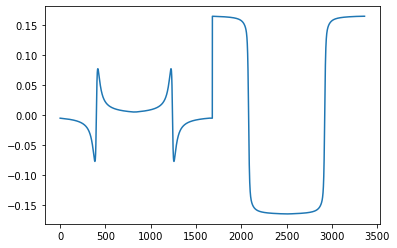

In [257]:
#Solving linear-inverse problems
u3T3_homogeneous=np.concatenate([u3_homogeneous_in-u3_homogeneous_out,T3_homogeneous_in-T3_homogeneous_out])
#print(u3T3_homogeneous.shape)
a=np.block([[-ker_u3_in,ker_u3_out],[-ker_T3_in,ker_T3_out]])
ustar_in_out=np.linalg.solve(a,u3T3_homogeneous)
#print(ustar_in_out)
ustar_in=ustar_in_out[0:Num_elements_tot]
ustar_out=ustar_in_out[Num_elements_tot:2*Num_elements_tot]
#print(ustar_in)
#print(ustar_out)
plt.plot(ustar_in_out)
#plt.plot(ustar_in)
#plt.plot(ustar_out)
plt.show()

In [18]:
#Defining vizualisation parameters (required in the following vizualisations) 
visualisedXandYrange=6
NUM_OF_DOTS=60

x1=np.arange(-visualisedXandYrange+visualisedXandYrange/NUM_OF_DOTS, visualisedXandYrange,2*visualisedXandYrange/NUM_OF_DOTS) 
x2=np.arange(-visualisedXandYrange+visualisedXandYrange/NUM_OF_DOTS, visualisedXandYrange,2*visualisedXandYrange/NUM_OF_DOTS) 
X2, X1= np.meshgrid(x1,x2)



In [258]:
#Computing deformation fields of the obtained DEI solution (required in the following vizualisations) 
u3_obtained=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep31_obtained=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep32_obtained=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))

homogeneous_solution_u3_in=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
homogeneous_solution_ep31_in=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
homogeneous_solution_ep32_in=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))

homogeneous_solution_u3_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
homogeneous_solution_ep31_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
homogeneous_solution_ep32_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))

u3_dueto_ustar_in= np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
u3_dueto_ustar_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep31_dueto_ustar_in= np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep31_dueto_ustar_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep32_dueto_ustar_in= np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
ep32_dueto_ustar_out=np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))

buffer_location=np.zeros(2)

for i in range(NUM_OF_DOTS):
    for j in range(NUM_OF_DOTS):
        buffer_location[0]=x1[i]
        buffer_location[1]=x2[j]
        homogeneous_solution_u3_out[i][j]=0.5*np.sign(x1[i])
        homogeneous_solution_ep31_out[i][j]=0
        homogeneous_solution_ep32_out[i][j]=0
        
        homogeneous_solution_u3_in[i][j]=  homogeneous_solution_u3_out[i][j]-discretised_u3_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        homogeneous_solution_ep31_in[i][j]=homogeneous_solution_ep31_out[i][j]-discretised_ep31_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
        homogeneous_solution_ep32_in[i][j]=homogeneous_solution_ep32_out[i][j]-discretised_ep32_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)

        homogeneous_solution_u3_out[i][j]=homogeneous_solution_u3_in[i][j]
        homogeneous_solution_ep31_out[i][j]=homogeneous_solution_ep31_in[i][j]
        homogeneous_solution_ep32_out[i][j]=homogeneous_solution_ep32_in[i][j]

        if((abs(x1[i])<0.5*Width_damagezone) and ((abs(x2[j]))<Length_damagezone)):            
            for k in range(Num_elements_tot):
                buf_relative_center_location=buffer_location-loc_elements_tot[k]                
                u3_dueto_ustar_in[i][j]=  u3_dueto_ustar_in[i][j]+  ustar_in[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
                ep31_dueto_ustar_in[i][j]=ep31_dueto_ustar_in[i][j]+ustar_in[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
                ep32_dueto_ustar_in[i][j]=ep32_dueto_ustar_in[i][j]+ustar_in[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            u3_obtained[i][j]  =homogeneous_solution_u3_in[i][j]  +u3_dueto_ustar_in[i][j]
            ep31_obtained[i][j]=homogeneous_solution_ep31_in[i][j]+ep31_dueto_ustar_in[i][j]
            ep32_obtained[i][j]=homogeneous_solution_ep32_in[i][j]+ep32_dueto_ustar_in[i][j] 
  
        else:         
            for k in range(Num_elements_tot):
                buf_relative_center_location=buffer_location-loc_elements_tot[k]                
                u3_dueto_ustar_out[i][j]=  u3_dueto_ustar_out[i][j]  +ustar_out[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
                ep31_dueto_ustar_out[i][j]=ep31_dueto_ustar_out[i][j]+ustar_out[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
                ep32_dueto_ustar_out[i][j]=ep32_dueto_ustar_out[i][j]+ustar_out[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            u3_obtained[i][j]  =homogeneous_solution_u3_out[i][j]  +u3_dueto_ustar_out[i][j]
            ep31_obtained[i][j]=homogeneous_solution_ep31_out[i][j]+ep31_dueto_ustar_out[i][j]
            ep32_obtained[i][j]=homogeneous_solution_ep32_out[i][j]+ep32_dueto_ustar_out[i][j]   

<ipython-input-110-adc259afd0a7>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_obtained)


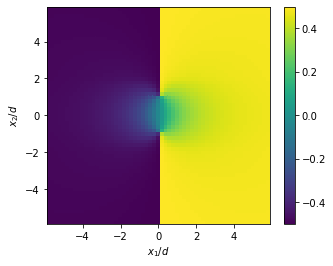

In [110]:
#Vizualising obtained DEI solutions 
fig = plt.figure(figsize=(5, 4))

plt.pcolor(X1, X2,u3_obtained) 
#plt.pcolor(X1, X2,u3_obtained-homogeneous_solution_u3_in) 
#plt.pcolor(X1, X2,homogeneous_solution_u3_in) 
#plt.pcolor(X1, X2,ep31_obtained) 
#plt.pcolor(X1, X2,ep32_obtained) 
plt.colorbar()
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 

# Comparison with a homogenous solution

Changing the ratio $\gamma=\mu_*/\mu_0$ (`ratio_MU_out_per_in` in the code, corresponding to `MU_out/MU_in`) of the rigidity ($\mu_*$ in the damage zone, $\mu_0$ in the other), the following compares the surface deformation between the inhomogeneous cases ($\gamma\neq1$) and the homogeneous case ($\gamma=1$).

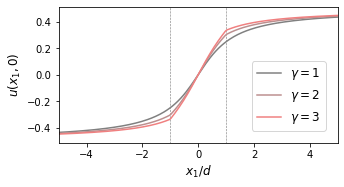

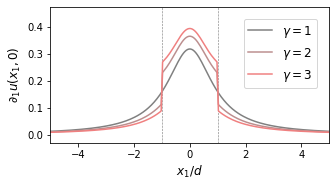

In [21]:
diff_u3_homogeneous_in_minus_out=np.zeros(Num_elements_tot)
diff_T3_homogeneous_in_minus_outA=np.zeros(Num_elements_tot)
diff_T3_homogeneous_in_minus_outB=np.zeros(Num_elements_tot)

ratio_MU_out_per_in=MU_out/MU_in

ratio_MU_out_per_inA=2
ratio_MU_out_per_inB=3
for i in range(Num_elements_tot):
    #difference of the reference traction of the inside from that of the outside
    diff_T3_homogeneous_in_minus_outA[i]=-discretised_traction_nuclei(loc_elements_tot[i],fault_length_original2,normal_original_source,normal_elements_tot_exterior[i],1-ratio_MU_out_per_inA) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)
    diff_T3_homogeneous_in_minus_outB[i]=-discretised_traction_nuclei(loc_elements_tot[i],fault_length_original2,normal_original_source,normal_elements_tot_exterior[i],1-ratio_MU_out_per_inB) #discretised_traction_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal,receiver_normal,medium_rigidity)


#Solving linear-inverse problems
u3T3_homogeneousA=np.concatenate([diff_u3_homogeneous_in_minus_out,diff_T3_homogeneous_in_minus_outA])
aA=np.block([[-ker_u3_in,ker_u3_out],[-ker_T3_in/MU_in,ker_T3_out/MU_out*ratio_MU_out_per_inA]])
ustar_in_outA=np.linalg.solve(aA,u3T3_homogeneousA)
ustar_inA=ustar_in_outA[0:Num_elements_tot]
ustar_outA=ustar_in_outA[Num_elements_tot:2*Num_elements_tot]
#plt.plot(ustar_in_outA)
#plt.show()

u3T3_homogeneousB=np.concatenate([diff_u3_homogeneous_in_minus_out,diff_T3_homogeneous_in_minus_outB])
aB=np.block([[-ker_u3_in,ker_u3_out],[-ker_T3_in/MU_in,ker_T3_out/MU_out*ratio_MU_out_per_inB]])
ustar_in_outB=np.linalg.solve(aB,u3T3_homogeneousB)
ustar_inB=ustar_in_outB[0:Num_elements_tot]
ustar_outB=ustar_in_outB[Num_elements_tot:2*Num_elements_tot]


NUM_OF_DOTS_fine=240
x1_fine=np.arange(-visualisedXandYrange+visualisedXandYrange/NUM_OF_DOTS_fine, visualisedXandYrange,2*visualisedXandYrange/NUM_OF_DOTS_fine) 

u3_obtainedA=np.zeros(NUM_OF_DOTS_fine)
ep31_obtainedA=np.zeros(NUM_OF_DOTS_fine)
ep32_obtainedA=np.zeros(NUM_OF_DOTS_fine)

u3_obtainedB=np.zeros(NUM_OF_DOTS_fine)
ep31_obtainedB=np.zeros(NUM_OF_DOTS_fine)
ep32_obtainedB=np.zeros(NUM_OF_DOTS_fine)

homogeneous_solution_u3A=np.zeros(NUM_OF_DOTS_fine)
homogeneous_solution_ep31A=np.zeros(NUM_OF_DOTS_fine)
homogeneous_solution_ep32A=np.zeros(NUM_OF_DOTS_fine)

buffer_location=np.zeros(2)

for i in range(NUM_OF_DOTS_fine):
    buffer_location[0]=x1_fine[i]
    buffer_location[1]=0

    homogeneous_solution_u3A[i]=  0.5*np.sign(x1_fine[i])-discretised_u3_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_u3_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
    homogeneous_solution_ep31A[i]=-discretised_ep31_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)
    homogeneous_solution_ep32A[i]=-discretised_ep32_nuclei(buffer_location,fault_length_original2,normal_original_source) #discretised_ep31_nuclei(relative_receiver_location_from_fault_center,fault_length,fault_normal)

    u3_obtainedA[i]=homogeneous_solution_u3A[i]
    ep31_obtainedA[i]=homogeneous_solution_ep31A[i]
    ep32_obtainedA[i]=homogeneous_solution_ep32A[i]
    
    u3_obtainedB[i]=homogeneous_solution_u3A[i]
    ep31_obtainedB[i]=homogeneous_solution_ep31A[i]
    ep32_obtainedB[i]=homogeneous_solution_ep32A[i]

        
    if((abs(buffer_location[0])<0.5*Width_damagezone) and ((abs(buffer_location[1]))<Length_damagezone)):            
        for k in range(Num_elements_tot):
            buf_relative_center_location=buffer_location-loc_elements_tot[k]                
            u3_obtainedA[i]=  u3_obtainedA[i]+  ustar_inA[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep31_obtainedA[i]=ep31_obtainedA[i]+ustar_inA[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep32_obtainedA[i]=ep32_obtainedA[i]+ustar_inA[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])  

            u3_obtainedB[i]=  u3_obtainedB[i]+  ustar_inB[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep31_obtainedB[i]=ep31_obtainedB[i]+ustar_inB[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep32_obtainedB[i]=ep32_obtainedB[i]+ustar_inB[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])  

    else:         
        for k in range(Num_elements_tot):
            buf_relative_center_location=buffer_location-loc_elements_tot[k]                
            u3_obtainedA[i]=  u3_obtainedA[i]  +ustar_outA[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep31_obtainedA[i]=ep31_obtainedA[i]+ustar_outA[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep32_obtainedA[i]=ep32_obtainedA[i]+ustar_outA[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])

            u3_obtainedB[i]=  u3_obtainedB[i]  +ustar_outB[k]*discretised_u3_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep31_obtainedB[i]=ep31_obtainedB[i]+ustar_outB[k]*discretised_ep31_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])
            ep32_obtainedB[i]=ep32_obtainedB[i]+ustar_outB[k]*discretised_ep32_nuclei(buf_relative_center_location,DX_tot,normal_elements_tot_exterior[k])


fig = plt.figure(figsize=(5, 2.5))
ax = fig.add_subplot(111)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$u(x_1,0)$', fontsize=12, fontname='Helvetica')
ax.plot(x1_fine,homogeneous_solution_u3A, color='gray', label="$\gamma=1$")
ax.plot(x1_fine,u3_obtainedA, color='rosybrown', label="$\gamma=2$")
ax.plot(x1_fine,u3_obtainedB, color='lightcoral', label="$\gamma=3$")
#ax.plot(x1,u3_obtainedB, color='coral', label="$\gamma=5$")
ax.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=12)
plt.vlines(-1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
plt.vlines(1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
ax.set_xlim(-5,5)
ax.set_ylim(-0.515,0.515)
#plt.savefig('comparison_box_u3.svg', bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(5, 2.5))
ax = fig.add_subplot(111)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$\partial_1 u(x_1,0)$', fontsize=12, fontname='Helvetica')
ax.plot(x1_fine,homogeneous_solution_ep31A, color='gray', label="$\gamma=1$")
ax.plot(x1_fine,ep31_obtainedA, color='rosybrown', label="$\gamma=2$")
ax.plot(x1_fine,ep31_obtainedB, color='lightcoral', label="$\gamma=3$")
ax.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=12)
plt.vlines(-1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
plt.vlines(1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
ax.set_xlim(-5,5)
ax.set_ylim(-0.03,0.475)
#plt.savefig('comparison_box_ep31.svg', bbox_inches="tight")
plt.show()




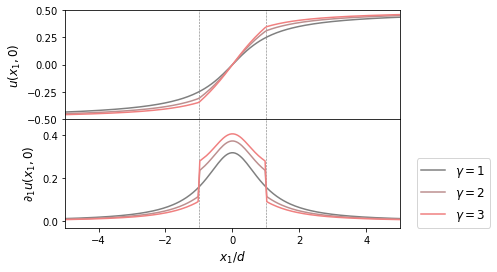

In [36]:
#visualisation script for the above comparison
fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0})

axs[1].set_xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
axs[1].set_xlim(-5,5)

axs[0].set_ylim(-0.501,0.501)
axs[0].set_ylabel('$u(x_1,0)$', fontsize=12, fontname='Helvetica')
axs[0].plot(x1_fine,homogeneous_solution_u3A, color='gray', label="$\gamma=1$")
axs[0].plot(x1_fine,u3_obtainedA, color='rosybrown', label="$\gamma=3$")
axs[0].plot(x1_fine,u3_obtainedB, color='lightcoral', label="$\gamma=5$")
axs[0].vlines(-1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
axs[0].vlines(1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
#axs[0].legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=12)
#axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

axs[1].set_ylim(-0.03,0.475)
axs[1].set_ylabel('$\partial_1 u(x_1,0)$', fontsize=12, fontname='Helvetica')
axs[1].plot(x1_fine,homogeneous_solution_ep31A, color='gray', label="$\gamma=1$")
axs[1].plot(x1_fine,ep31_obtainedA, color='rosybrown', label="$\gamma=2$")
axs[1].plot(x1_fine,ep31_obtainedB, color='lightcoral', label="$\gamma=3$")
axs[1].vlines(-1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
axs[1].vlines(1, -1,1,color='gray',linestyle='dashed',linewidth=.6)
axs[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0, fontsize=12)
#axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)


# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

plt.savefig('comparison_box_u3_ep31.svg', bbox_inches="tight")


# Comparison with Benchmark 1

Scripts to compare the obtained DEI solution with the analytic solution of the Benchmark 1.

The following assumes that the deformation fields of the DEI solution is computed already in the previous script with the value assignment of the vizualisation parameters.

<ipython-input-22-f9465c0cf997>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2, u3_analytic)


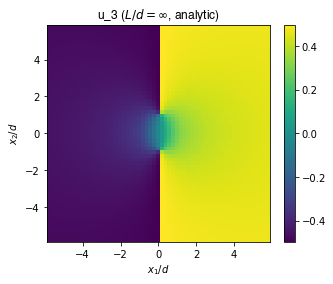

In [22]:
#Benchmark 1: analytic solution for Length_damagezone=infinity (Segall, 2010, eq. 5.23)
kappa=(MU_out-MU_in)/(MU_out+MU_in)
u3_analytic= np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
buf_location=np.zeros(2)

for i in range(NUM_OF_DOTS):
    for j in range(NUM_OF_DOTS):
        if (abs(x1[i])>0.5*Width_damagezone): 
            for n in range(1,100):
                u3_analytic[i][j]=u3_analytic[i][j]+kappa**n*math.atan2((x1[i]+np.sign(x1[i])*n*Width_damagezone),(x2[j]+1))
                u3_analytic[i][j]=u3_analytic[i][j]+kappa**n*math.atan2((x1[i]+np.sign(x1[i])*n*Width_damagezone),-(x2[j]-1))
            u3_analytic[i][j]=u3_analytic[i][j]+math.atan2(x1[i],(x2[j]+1))
            u3_analytic[i][j]=u3_analytic[i][j]+math.atan2(x1[i],-(x2[j]-1))
            u3_analytic[i][j]=u3_analytic[i][j]*(1-kappa)/(2*math.pi)
        else:
            for n in range(1,100):
                u3_analytic[i][j]=u3_analytic[i][j]+kappa**n*(math.atan2((x1[i]+n*Width_damagezone),(x2[j]+1))+math.atan2((x1[i]-n*Width_damagezone),(x2[j]+1)))
                u3_analytic[i][j]=u3_analytic[i][j]+kappa**n*(math.atan2((x1[i]+n*Width_damagezone),-(x2[j]-1))+math.atan2((x1[i]-n*Width_damagezone),-(x2[j]-1)))
            u3_analytic[i][j]=u3_analytic[i][j]+math.atan2(x1[i],(x2[j]+1))
            u3_analytic[i][j]=u3_analytic[i][j]+math.atan2(x1[i],-(x2[j]-1)) 
            u3_analytic[i][j]=u3_analytic[i][j]/(2*math.pi)
        buf_location[0]=x1[i]
        buf_location[1]=x2[j]
        

fig = plt.figure(figsize=(5, 4))
X2, X1= np.meshgrid(x1,x2)
#plt.pcolor(x1, x2,homogeneous_solution_u3_in) 
#plt.pcolor(x1, x2,u3_analytic-homogeneous_solution_u3_in)
plt.pcolor(X1, X2, u3_analytic)
plt.colorbar()
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.title('u_3 ($L/d=\infty$, analytic)', fontname='Helvetica')
plt.show() 
 

<ipython-input-23-68b6b6b36cb4>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_obtained)


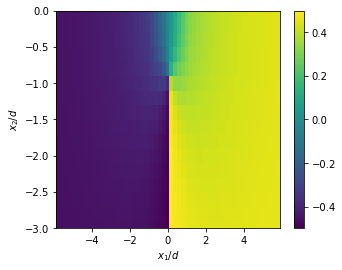

<ipython-input-23-68b6b6b36cb4>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_analytic)


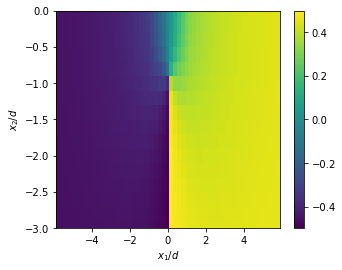

<ipython-input-23-68b6b6b36cb4>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_analytic/u3_obtained-1)


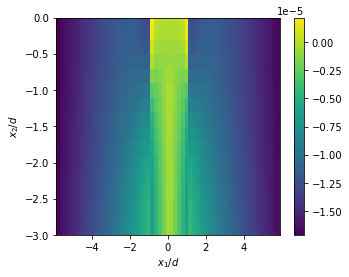

In [23]:
#quick comparison between obtained deformation fields and Benchmark 1
fig = plt.figure(figsize=(5, 4))
plt.pcolor(X1, X2,u3_obtained) 
plt.colorbar()
plt.ylim([-3,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 
fig = plt.figure(figsize=(5, 4))
#plt.pcolor(X1, X2,homogeneous_solution_u3_in) 
plt.pcolor(X1, X2,u3_analytic) 
plt.colorbar()
plt.ylim([-3,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 

fig = plt.figure(figsize=(5, 4))
plt.pcolor(X1, X2,u3_analytic/u3_obtained-1) 
plt.colorbar()
plt.ylim([-3,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 



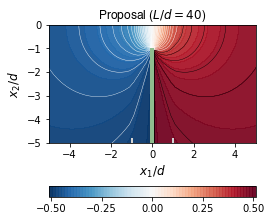

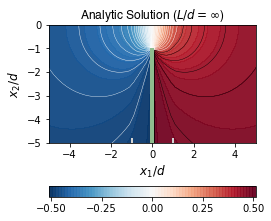

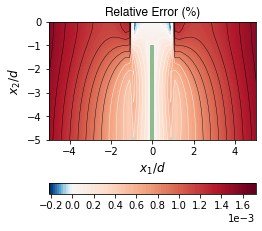

In [251]:
#Visualisation script in comparing the computational DEI solution and Benchmark 1
#(L/d=40 is assumed in the figure) 

from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
cpf = ax.contourf(X1,X2,u3_obtained, 80, cmap=cm.RdBu_r,alpha=0.95)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cpf.set_clim(-0.505,0.505)
#plt.colorbar(cpf,ticks=[-0.50,-0.375,-0.250,-0.125,0.00,0.125,0.250,0.375,0.50])
plt.colorbar(cpf,ticks=[-0.50,-0.250,0.00,0.250,0.50], orientation='horizontal', pad=0.23)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
cp = ax.contour(X1,X2,u3_obtained, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Proposal ($L/d=40$)', fontname='Helvetica')
plt.vlines(-1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_vertical_prop.svg', bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
cpf = ax.contourf(X1,X2,u3_analytic, 80, cmap=cm.RdBu_r,alpha=0.95)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cpf.set_clim(-0.505,0.505)
plt.colorbar(cpf,ticks=[-0.50,-0.250,0.00,0.250,0.50], orientation='horizontal', pad=0.23)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
cp = ax.contour(X1,X2,u3_analytic, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Analytic Solution ($L/d=\infty$)', fontname='Helvetica')
plt.vlines(-1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_vertical_analytic.svg', bbox_inches="tight")
plt.show()


fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
vmin, vmax, vcenter = -0.0002, 0.0017, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cpf = ax.contourf(X1,X2,(u3_obtained-u3_analytic)/u3_analytic*100, 100, cmap=cm.RdBu_r,norm=norm)
#cpf = ax.contourf(X1,X2,u3_obtained-u3_analytic, 100, cmap=cm.RdBu_r)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cbar =fig.colorbar(cpf,orientation='horizontal', pad=0.23)
#ticks=[-2.*10**(-4),0,10**(-4)*5,10**(-4)*10,10**(-4)*15], 
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
#cpf.set_clim(-0.00001,0.00001)
cp = ax.contour(X1,X2,(u3_obtained-u3_analytic)/u3_analytic*100, 20,linewidths=0.4, colors=colours)
#cp = ax.contour(X1,X2,u3_obtained-u3_analytic, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Relative Error (%)', fontname='Helvetica')
#ax.set_title('Residual', fontname='Helvetica')
plt.vlines(-1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(1, -6,-4.8,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_vertical_res.svg', bbox_inches="tight")
plt.show()





# Comparison with Benchmark 2

Scripts to compare the obtained DEI solution with the analytic solution of Benchmark 2.

The following assumes that the deformation fields of the DEI solution is computed already in the previous script with the value assignment of the vizualisation parameters.

<ipython-input-111-99367a6c1fcd>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2, u3_analytic_2)


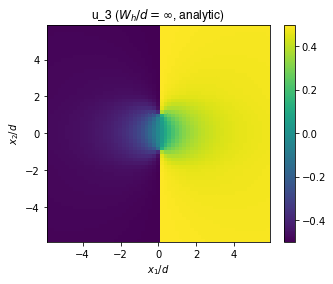

In [111]:
#Benchmark 2: analytic solution for Width_damagezone=infinity (after Segall, 2010, eq. 5.32, 5.34)
kappa=-(MU_out-MU_in)/(MU_out+MU_in) #sign is flipped from that of Length_damagezone=infinity
u3_analytic_2= np.zeros((NUM_OF_DOTS,NUM_OF_DOTS))
buf_location=np.zeros(2)

for i in range(NUM_OF_DOTS):
    for j in range(NUM_OF_DOTS):
        if (abs(x2[j])>Length_damagezone): 
            for n in range(1,100):
                u3_analytic_2[i][j]=u3_analytic_2[i][j]-kappa**n*math.atan2((x1[i]),(x2[j]+1+np.sign(x2[j])*n*2*Length_damagezone))
                u3_analytic_2[i][j]=u3_analytic_2[i][j]+kappa**n*math.atan2((x1[i]),(x2[j]-1+np.sign(x2[j])*n*2*Length_damagezone))
            u3_analytic_2[i][j]=u3_analytic_2[i][j]-math.atan2(x1[i],(x2[j]+1)) #modified after a part of eq. 5.32 of Segall (2010)   
            u3_analytic_2[i][j]=u3_analytic_2[i][j]+math.atan2(x1[i],(x2[j]-1)) #modified after a part of eq. 5.32 of Segall (2010)
            #u3_analytic_2[i][j]=u3_analytic_2[i][j]-math.atan2((x2[j]-1),x1[i])  #a part of eq. 5.32 of Segall (2010)   
            #u3_analytic_2[i][j]=u3_analytic_2[i][j]+math.atan2((x2[j]+1),x1[i])  #a part of eq. 5.32 of Segall (2010) 
            #print(-math.atan2(x1[i],(x2[j]+1))+math.atan2(x1[i],(x2[j]-1))-(-math.atan2((x2[j]-1),x1[i])+math.atan2((x2[j]+1),x1[i]))) #checking the invariance of the solution against the modification
            u3_analytic_2[i][j]=u3_analytic_2[i][j]*(1+kappa)/(2*math.pi)
            u3_analytic_2[i][j]=0.5*np.sign(x1[i])-u3_analytic_2[i][j] #subtracting back slip
        else:
            for n in range(1,100):
                u3_analytic_2[i][j]=u3_analytic_2[i][j]-kappa**n*math.atan2((x1[i]),(x2[j]+1+n*2*Length_damagezone))
                u3_analytic_2[i][j]=u3_analytic_2[i][j]+kappa**n*math.atan2((x1[i]),(x2[j]-1+n*2*Length_damagezone))
                u3_analytic_2[i][j]=u3_analytic_2[i][j]-kappa**n*math.atan2((x1[i]),(x2[j]+1-n*2*Length_damagezone)) #to construct mirror
                u3_analytic_2[i][j]=u3_analytic_2[i][j]+kappa**n*math.atan2((x1[i]),(x2[j]-1-n*2*Length_damagezone)) #to construct mirror

            u3_analytic_2[i][j]=u3_analytic_2[i][j]-math.atan2(x1[i],(x2[j]+1))
            u3_analytic_2[i][j]=u3_analytic_2[i][j]+math.atan2(x1[i],(x2[j]-1)) #to construct mirror
            u3_analytic_2[i][j]=u3_analytic_2[i][j]/(2*math.pi)
            u3_analytic_2[i][j]=0.5*np.sign(x1[i])-u3_analytic_2[i][j] #subtracting back slip
        buf_location[0]=x1[i]
        buf_location[1]=x2[j]

fig = plt.figure(figsize=(5, 4))
plt.pcolor(X1, X2, u3_analytic_2)
plt.colorbar()
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.title('u_3 ($W_h/d=\infty$, analytic)', fontname='Helvetica')
plt.show() 

<ipython-input-112-d880e3abf77d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_obtained)


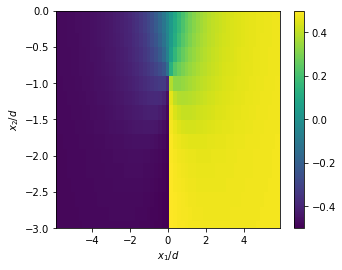

<ipython-input-112-d880e3abf77d>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_analytic_2+np.fliplr(u3_analytic_2))


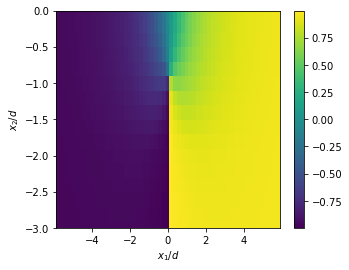

<ipython-input-112-d880e3abf77d>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X1, X2,u3_analytic_2-u3_obtained)


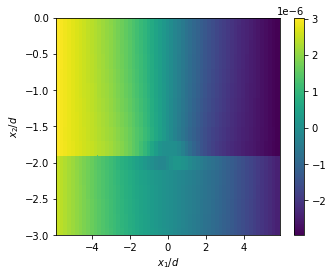

In [112]:
#quick comparison between obtained deformation fields and Benchmark 2
fig = plt.figure(figsize=(5, 4))
plt.pcolor(X1, X2,u3_obtained) 
plt.colorbar()
plt.ylim([-3.,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 
fig = plt.figure(figsize=(5, 4))
#plt.pcolor(X1, X2,homogeneous_solution_u3_in) 
plt.pcolor(X1, X2,u3_analytic_2+np.fliplr(u3_analytic_2)) 
plt.colorbar()
plt.ylim([-3.,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 

fig = plt.figure(figsize=(5, 4))
plt.pcolor(X1, X2,u3_analytic_2-u3_obtained)
plt.colorbar()
plt.ylim([-3,0])
plt.xlabel('$x_1/d$')
plt.ylabel('$x_2/d$') #x_2>0 shows the mirror deformation
plt.show() 



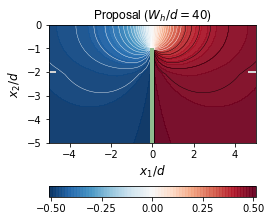

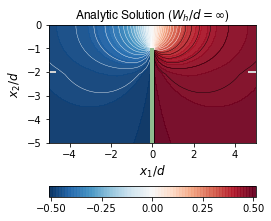

In [ ]:
#Visualisation script in comparing the computational DEI solution and Benchmark 2
#(W/d=80 (W_h/d=40) is assumed in the figure) 

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator


fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
cpf = ax.contourf(X1,X2,u3_obtained, 80, cmap=cm.RdBu_r,alpha=0.95)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cpf.set_clim(-0.505,0.505)
#plt.colorbar(cpf,ticks=[-0.50,-0.375,-0.250,-0.125,0.00,0.125,0.250,0.375,0.50])
plt.colorbar(cpf,ticks=[-0.50,-0.250,0.00,0.250,0.50], orientation='horizontal', pad=0.23)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
cp = ax.contour(X1,X2,u3_obtained, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Proposal ($W_h/d=40$)', fontname='Helvetica')
plt.hlines(-2, -6,-4.65,'lightgray',linewidth=2.)
plt.hlines(-2, 4.65,6,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_horizontal_prop.svg', bbox_inches="tight")
plt.show()



fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
cpf = ax.contourf(X1,X2,u3_analytic_2, 80, cmap=cm.RdBu_r,alpha=0.95)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cpf.set_clim(-0.505,0.505)
plt.colorbar(cpf,ticks=[-0.50,-0.250,0.00,0.250,0.50], orientation='horizontal', pad=0.23)
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
cp = ax.contour(X1,X2,u3_analytic_2, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Analytic Solution ($W_h/d=\infty$)', fontname='Helvetica')
plt.hlines(-2, -6,-4.65,'lightgray',linewidth=2.)
plt.hlines(-2, 4.65,6,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_horizontal_analytic.svg', bbox_inches="tight")
plt.show()



fig = plt.figure(figsize=(3.7, 3.5))
ax = fig.add_subplot(111)
vmin, vmax, vcenter = -0.0001, 0.00075, 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cpf = ax.contourf(X1,X2,(u3_obtained-u3_analytic_2)/u3_analytic_2*100, 100, cmap=cm.RdBu_r,norm=norm)
#cpf = ax.contourf(X1,X2,u3_obtained-u3_analytic_2, 100, cmap=cm.RdBu_r)
colours = ['w' if level<0 else 'k' for level in cpf.levels]
cbar =fig.colorbar(cpf, orientation='horizontal', pad=0.23)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
plt.xlabel('$x_1/d$', fontsize=12, fontname='Helvetica')
plt.ylabel('$x_2/d$', fontsize=12, fontname='Helvetica')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 0)
#cpf.set_clim(-0.00001,0.00001)
cp = ax.contour(X1,X2,(u3_obtained-u3_analytic_2)/u3_analytic_2*100, 10,linewidths=0.4, colors=colours)
#cp = ax.contour(X1,X2,u3_obtained-u3_analytic_2, 40,linewidths=0.4, colors=colours)
#ax.clabel(cp, fontsize=12, colors=colours)
ax.set_title('Relative Error (%)', fontname='Helvetica')
#ax.set_title('Residual', fontname='Helvetica')
plt.hlines(-2, -6,-4.65,'lightgray',linewidth=2.)
plt.hlines(-2, 4.65,6,'lightgray',linewidth=2.)
plt.vlines(0, -6,-1,'darkseagreen',linewidth=4.)
plt.savefig('comparison_horizontal_res.svg', bbox_inches="tight")
plt.show()

